In [ ]:
#dataset download from https://drive.google.com/drive/folders/1b9MDxdcruit1Y2RfC6ylQJOeyg9tEel9?usp=sharing

from google.colab import drive #mouting google drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import os #importing os for file execution such as read and write
import numpy as np # for mathematical calculations
import shutil #for copying or deleting files 
from skimage import io #for reading and writing images 
from skimage.color import rgb2hsv #for color feature extraction
from skimage.feature import hog #for HOG extraction
from skimage.transform import resize #for resizing 
from scipy.stats import skew #for statistical calculation such as skew
import matplotlib.pyplot as plt #for plotting graphs
import matplotlib.image as mpimg #for better visualizations
import seaborn as sns #for better visualizations
import tensorflow as tf #for importing tensorflow for deep learning
from tqdm import tqdm #for showing time
from tensorflow.keras.preprocessing.image import ImageDataGenerator #
from tensorflow.keras.applications.vgg16 import VGG16 #importing the VGG16 pre-trained model for fine tuning
from tensorflow.keras.layers import Dense, Flatten, Dropout #importing layers for deep learning
from tensorflow.keras.models import Model #for grouping layers into an object
from tensorflow.keras.optimizers import Adam #importing adam optimizer
from sklearn.model_selection import train_test_split #for splitting the dataset
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.ensemble import RandomForestClassifier #for importing randomforest
from sklearn.metrics import classification_report #for classification report
from skimage.feature import local_binary_pattern #for LBP feature processing 
from skimage.filters import sobel #for edge detection
from skimage.color import rgb2gray #for converting rgb to gray
from sklearn.preprocessing import StandardScaler #for scaling to unit variance
from sklearn.impute import SimpleImputer #for imputing missing values. 





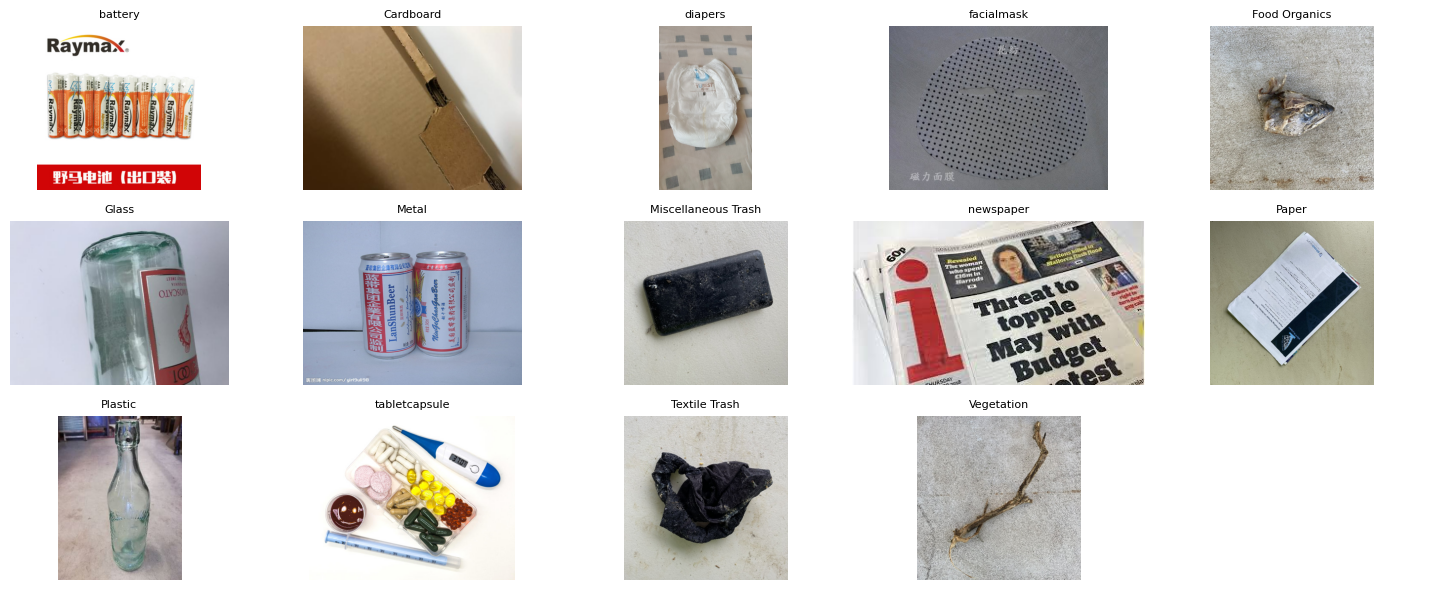

In [ ]:
def display_sample_images(dataset_path, categories):

    num_categories = len(categories) #check the number of categories
    cols = 5  # Number of columns per row
    rows = -(-num_categories // cols)  # number of rows to implement

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 2))  # adjusting the graph size
    axes = axes.ravel()  # flattening the axes in order for easy indexing

    for i, category in enumerate(categories): 
        category_path = os.path.join(dataset_path, category)
        image_files = os.listdir(category_path) #checking the path for the dataset and checking the image files. 

        if image_files:
            img_path = os.path.join(category_path, image_files[0])  # Take the first image from each category
            img = mpimg.imread(img_path) #read the image path
            axes[i].imshow(img) #show the image
            axes[i].axis('off') #axis is set to off since its image
            axes[i].set_title(category, fontsize=8) #title is set to category name

    # If there is any unused subplot, then turn it off. 
    for j in range(i + 1, rows * cols):
        axes[j].axis('off') 

    plt.tight_layout() #in order to make the graph compact
    plt.show() #show the graph

dataset_path = '/content/drive/MyDrive/DS_Project_New/realwaste-main/Waste' #path to dataset
categories = ['battery', 'Cardboard', 'diapers', 'facialmask', 'Food Organics', 'Glass', 'Metal', 
              'Miscellaneous Trash', 'newspaper', 'Paper', 'Plastic', 'tabletcapsule',
              'Textile Trash', 'Vegetation'] #total categories present 
display_sample_images(dataset_path, categories) #display the image


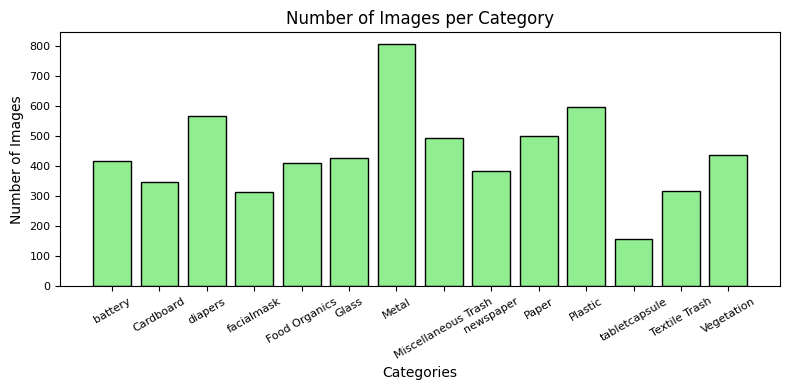

In [ ]:
image_counts = {} #list for image count
for category in categories: #iterating over categories. 
    category_path = os.path.join(dataset_path, category) #iterating in the path of dataset where it is present and iterating over categories
    image_counts[category] = len([file for file in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, file))]) #checking the count of each category
 
plt.figure(figsize=(8, 4))  # Setting for a compact look
plt.bar(image_counts.keys(), image_counts.values(), color='lightgreen', edgecolor='black')  #color setup for visualization


plt.xlabel('Categories', fontsize=10) #setting x-label
plt.ylabel('Number of Images', fontsize=10) #setting y-label
plt.title('Number of Images per Category', fontsize=12) #setting the title

plt.xticks(rotation=30, fontsize=8)  #set less rotation and set font size for xticks
plt.yticks(fontsize=8) #set font size for y ticks
plt.tight_layout()  # for compact look.

# Display the plot
plt.show()


In [ ]:
filtered_categories = [category for category in categories if image_counts[category] >= 400] #condition for if the image data is over 400 or not and get final dataset as filtered_categories

def delete_unwanted_files(path, allowed_extensions=('.jpg', '.jpeg', '.png')): 
    for file in os.listdir(path): #check in the path
        if not file.lower().endswith(allowed_extensions): #if the file is not of the followinf extension 
            os.remove(os.path.join(path, file)) #remove it

# Deleting files that have unwanted extensions
for category in filtered_categories: #iterate over categories
    category_path = os.path.join(dataset_path, category) 
    delete_unwanted_files(category_path) #loop for other category once its finished for certain category.


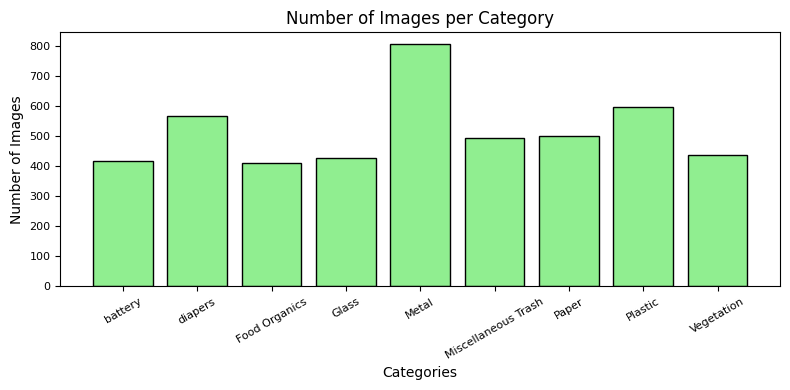

In [ ]:
image_counts = {} #set the image count list
for category in filtered_categories: #iterate once again through filtered categories. 
    category_path = os.path.join(dataset_path, category)
    image_counts[category] = len([file for file in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, file))]) #calculate the number of data in each categories

plt.figure(figsize=(8, 4))  # Setting for a compact look
plt.bar(image_counts.keys(), image_counts.values(), color='lightgreen', edgecolor='black')  #color setup for visualization

plt.xlabel('Categories', fontsize=10) #setting x-label
plt.ylabel('Number of Images', fontsize=10) #setting y-label
plt.title('Number of Images per Category', fontsize=12) #setting the title

plt.xticks(rotation=30, fontsize=8)  #set less rotation and set font size for xticks
plt.yticks(fontsize=8) #set font size for yticks
plt.tight_layout()  # for compact look.

# Display the plot
plt.show()



**Extraction of Features (HOG, Color Features, LBP, and Canopy Edge Detection)**

In [ ]:
# Extracting HOG features
def extract_hog_features(image): #image is taken as input
    features, _ = hog(image, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=True) #for computing HOG for a given image. 
    return features #return HOG features


# Histogram and color moments extraction
def extract_color_features(image, bins=8, include_moments=True): #image is taken as input to calculate the color features
    hsv_image = rgb2hsv(image) #converting rgb to hsv values
    color_features = [] #color feature list
    for channel in range(3): #iterate over each H, S, and V
        hist, _ = np.histogram(hsv_image[:, :, channel], bins=bins, range=(0, 1)) #compute histogram
        color_features.extend(hist) #add histogram to color_features
        if include_moments: #calculate the mean, SD, and skewness
            channel_data = hsv_image[:, :, channel].flatten()
            color_features.extend([np.mean(channel_data), np.std(channel_data), skew(channel_data)]) #flatten the HSV data to 1D array and append to color_features
    return np.array(color_features) #returns list of color_features

# Computing texture using LBP
def extract_texture_features(image, P=8, R=1): #using image as input image with parameter P and radius 1
    gray_image = rgb2gray(image)  # Convert to grayscale
    lbp = local_binary_pattern(gray_image, P=P, R=R, method='uniform') #compute LBP
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P*R + 3), range=(0, P*R + 2)) #compute the histogram for the LBP
    return lbp_hist #return histogram

# Function to compute shape features using edge detection
def extract_shape_features(image): #take input as image
    edge_image = sobel(rgb2gray(image)) #apply sobel operator
    edge_features = np.histogram(edge_image, bins=10, range=(0, 1))[0] #calculate the shape features using edge detection
    return edge_features #return shape features




In [ ]:
# Assuming the functions extract_hog_features, extract_color_features, extract_texture_features, extract_shape_features are defined

X = [] #holds the value for appended features 
y = [] #holds the categories 

# Using filtered_categories which contain categories with 400 or more images
for category in filtered_categories: #loop over filtered_categories
    category_path = os.path.join(dataset_path, category) #iterate it in the dataset path
    image_files = os.listdir(category_path) #list all the present files inside the directory
    for image_file in tqdm(image_files, desc=f"Processing {category}"): #display a progress bar using tqdm and start loop over image category
        image_path = os.path.join(category_path, image_file) #path to current file
        image = io.imread(image_path) #read the image 
        image_resized = resize(image, (128, 128), anti_aliasing=True) #resize the image to 128x128 pixels

        # Extract various features from the image
        hog_features = extract_hog_features(image_resized) #extract HOG for resized image
        color_features = extract_color_features(image_resized) #extract color features for resized image
        texture_features = extract_texture_features(image_resized) #extract texture features for resized image
        shape_features = extract_shape_features(image_resized) #extract shape features for resized image

        # Combine all extracted features into a single feature vector
        combined_features = np.concatenate((hog_features, color_features, texture_features, shape_features))

        X.append(combined_features) #append the combined features to X
        y.append(category) #append the categories to X

X = np.array(X) #convert to numpy array
y = np.array(y) #convert to numpy array

Processing battery:   0%|          | 0/417 [00:00<?, ?it/s]<ipython-input-9-54fca2929e1c>:3: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, _ = hog(image, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=True)
Processing Vegetation: 100%|██████████| 436/436 [00:26<00:00, 16.43it/s]


In [ ]:
# from skimage import io, color, transform
# from skimage.feature import hog
# import numpy as np

# def extract_hog_features(image):
#     # Use 'channel_axis' argument instead of 'multichannel'
#     features, _ = hog(image, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, channel_axis=-1)
#     return features


# sample_image_path = '/content/drive/MyDrive/DS_Project_New/realwaste-main/Waste/Vegetation/Vegetation_10.jpg'

# # Read and process the sample image
# sample_image = io.imread(sample_image_path)
# sample_image_resized = transform.resize(sample_image, (128, 128))  # Resize to the expected input size for your HOG feature extractor

# # Extract HOG features from this sample image
# hog_features = extract_hog_features(sample_image_resized)

# # Get the length of the HOG feature vector
# len_hog = len(hog_features)

# print(f"The length of the HOG feature vector is: {len_hog}")


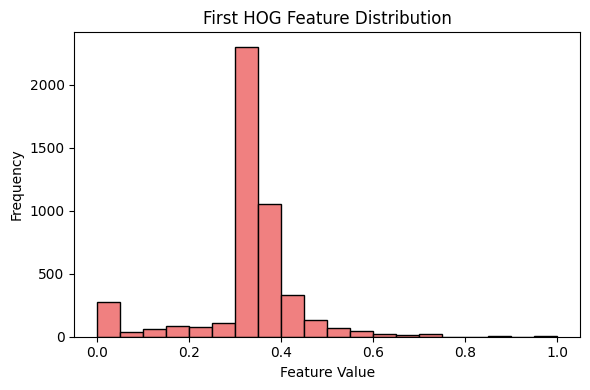

In [ ]:
len_hog = 576  # number of features in HOG from previous code. 

first_hog_feature = X[:, 0] #extracting first hog feature from all the images. 

plt.figure(figsize=(6, 4))  # compact figure size
plt.hist(first_hog_feature, bins=20, color='lightcoral', edgecolor='black')  # less bins and setting up color
plt.title('First HOG Feature Distribution') #setting the title
plt.xlabel('Feature Value') #setting the x label
plt.ylabel('Frequency') #setting the y label
plt.tight_layout()  # Adjusting for compact layout
plt.show() #show the graph



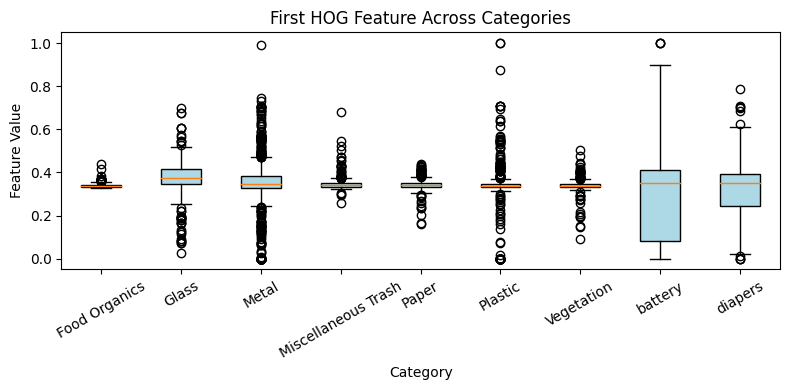

In [ ]:
category_labels = np.unique(y) #prepare the data for box plot graph
box_plot_data = [X[y == category, 0] for category in category_labels]

plt.figure(figsize=(8, 4))  # compact figure size
plt.boxplot(box_plot_data, labels=category_labels, patch_artist=True, boxprops=dict(facecolor='lightblue'))  # Styled box
plt.title('First HOG Feature Across Categories') #setting the title
plt.xlabel('Category') #setting the x label
plt.ylabel('Feature Value') #setting the y label
plt.xticks(rotation=30)  # setting rotation for 30
plt.tight_layout()  # Appy tight layout
plt.show() #show the graph



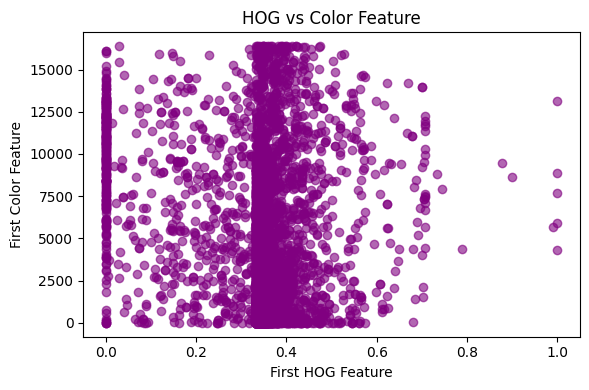

In [ ]:
start_color = len_hog #start the color of the hog with the total numbe of hog ie 576
first_color_feature = X[:, start_color] #extract color feature for all images

plt.figure(figsize=(6, 4))  # Smaller figure size
plt.scatter(first_hog_feature, first_color_feature, alpha=0.6, color='purple')  # Adjusting the alpha and color
plt.title('HOG vs Color Feature') #setting the title
plt.xlabel('First HOG Feature') #setting the x label
plt.ylabel('First Color Feature')#setting the y label
plt.tight_layout()  # setting tight layout
plt.show() #show the graph



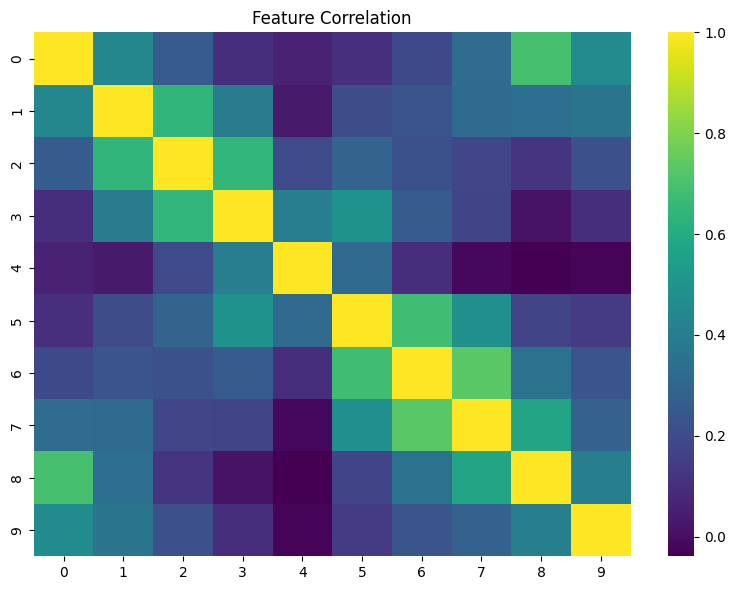

In [ ]:
# Using a subset of features for correlation matrix
subset_features = X[:, :10]  # include mix of features. only first 10 are included. 
correlation_matrix = np.corrcoef(subset_features, rowvar=False) #calculating correaltion matrix

plt.figure(figsize=(8, 6))  # Smaller figure size
sns.heatmap(correlation_matrix, annot=False, cmap='viridis')  # for cleaner look
plt.title('Feature Correlation') #adjusting title
plt.tight_layout()  # Adjusting tight layout for compact look
plt.show() #show graph



In [ ]:
# Dropping the rows with NaN values from X and y
mask = ~np.isnan(X).any(axis=1)
X = X[mask]
y = y[mask] 

# Impute NaN values with the mean of each column if there are dropped values present
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42) # Spliting the dataset

# Initialize and train the Random Forest model with forest = 100, and random state for SEED. 
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train) #train the dataset
 
# Predicting on the test set data
y_pred_rf = rf_model.predict(X_test)

# Evaluating the Random Forest model using classification report
print("Random Forest Model Evaluation:")
print(classification_report(y_test, y_pred_rf))



Random Forest Model Evaluation:
                     precision    recall  f1-score   support

      Food Organics       0.83      0.76      0.79        94
              Glass       0.93      0.91      0.92        85
              Metal       0.61      0.65      0.63       152
Miscellaneous Trash       0.58      0.67      0.62        88
              Paper       0.84      0.88      0.86       103
            Plastic       0.75      0.65      0.70       113
         Vegetation       0.79      0.94      0.86        83
            battery       0.70      0.52      0.60        98
            diapers       0.89      0.92      0.91       115

           accuracy                           0.76       931
          macro avg       0.77      0.77      0.76       931
       weighted avg       0.76      0.76      0.76       931



In [ ]:
dataset_path = '/content/drive/MyDrive/DS_Project_New/realwaste-main/RealWaste' #dataset path
train_path = os.path.join(dataset_path, 'train') #train data path
validation_path = os.path.join(dataset_path, 'validation') #test data path
split_ratio = 0.8 #splitting 80% for train and 20% for test

os.makedirs(train_path, exist_ok=True) #creating train directory if it doesnt exist
os.makedirs(validation_path, exist_ok=True) #creating test directory if it doesnt exist

# List of all the categories to process through
categories_to_process = [category for category in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, category)) and category not in ['train', 'validation']]

for category in categories_to_process: #iterating over categories to process
    category_path = os.path.join(dataset_path, category) #specifying path
    os.makedirs(os.path.join(train_path, category), exist_ok=True) #if it exists then join
    os.makedirs(os.path.join(validation_path, category), exist_ok=True) #if validation exists thne join

    image_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))] #join the image files
    np.random.shuffle(image_files) #shuffle the image files

    split_index = int(len(image_files) * split_ratio) #setting split index
    train_files = image_files[:split_index] #using the number of split index, split for train_files
    validation_files = image_files[split_index:]#using the reamianing number of split index, split for validation_files

    print(f"Processing category: {category}") 

    for f in train_files:
        src = os.path.join(category_path, f) #join the images from path
        dst = os.path.join(train_path, category, f) #join to the train_path
        shutil.copy2(src, dst) #copy files

    for f in validation_files:
        src = os.path.join(category_path, f) #join the images from path
        dst = os.path.join(validation_path, category, f)#join to the validation_path
        shutil.copy2(src, dst)#copy files

print("Dataset splitting completed.")


Processing category: battery
Processing category: diapers
Processing category: Food Organics
Processing category: Glass
Processing category: Metal
Processing category: Miscellaneous Trash
Processing category: Paper
Processing category: Plastic
Processing category: Vegetation
Dataset splitting completed.


In [ ]:
def count_images_in_directory(directory): #iterate to see how many images are present in the dataset. 
    
    category_counts = {} #list of category and image count
    for category in os.listdir(directory): 
        category_path = os.path.join(directory, category) #iterate over the directory and the specific catefory
        if os.path.isdir(category_path): #iterate in a specific catefory
            image_count = len([name for name in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, name))]) #finding the number of image
            category_counts[category] = image_count #setting the count according to the category
    return category_counts

dataset_path = '/content/drive/MyDrive/DS_Project_New/realwaste-main/Waste' #datset path
train_path = os.path.join(dataset_path, 'train') #train path
validation_path = os.path.join(dataset_path, 'validation') #validation path

# Count images in train and validation folders
train_counts = count_images_in_directory(train_path) #count image in train folder
validation_counts = count_images_in_directory(validation_path)  #count image in validation folder

# Print the counts
print("Number of images in each category in the Training folder:")
for category, count in train_counts.items():
    print(f"{category}: {count}")

print("\nNumber of images in each category in the Validation folder:")
for category, count in validation_counts.items():
    print(f"{category}: {count}")


Number of images in each category in the Training folder:
battery: 333
diapers: 452
Food Organics: 328
Glass: 341
Metal: 644
Miscellaneous Trash: 396
Paper: 400
Plastic: 477
Vegetation: 348

Number of images in each category in the Validation folder:
battery: 84
diapers: 114
Food Organics: 83
Glass: 86
Metal: 161
Miscellaneous Trash: 99
Paper: 100
Plastic: 120
Vegetation: 88


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255, #rescale the image
    rotation_range=40, #rotate the image
    width_shift_range=0.2, #shift the width
    height_shift_range=0.2, #shift the height
    shear_range=0.2, #shear the image
    zoom_range=0.2, #zoom on the range
    horizontal_flip=True, #flip horizontally
    fill_mode='nearest' #fill to nearest 
)

validation_datagen = ImageDataGenerator(rescale=1./255) #do only rescaling for validation data in order to predict accuracy


train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'), #dataset path for train
    target_size=(128, 128), #size of image is 128x128
    batch_size=32, #batch size is set to 32
    class_mode='categorical' #for classification problems, set to categorical
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(dataset_path, 'validation'), #dataset path for validation
    target_size=(128, 128), #size of image is 128x128
    batch_size=32, #batch size is set to 32
    class_mode='categorical' #for classification problems, set to categorical
)


Found 3719 images belonging to 9 classes.
Found 935 images belonging to 9 classes.


In [ ]:
# Load the VGG16 model, pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers on top of the base model
x = Flatten()(base_model.output) #flatten layer
x = Dense(512, activation='relu')(x) #dense layer with relu activation
x = Dropout(0.5)(x) #dropout
predictions = Dense(train_generator.num_classes, activation='softmax')(x) #dense layer to prevent overfitting

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary() #summary of the model


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
# Train the model using 10 epochs, the train generator data for training data and validation_generator data for validation data. The step per epoch is defined accrding to total dataset/batch size
train_model1 = model.fit(train_generator, validation_data=validation_generator, epochs=10, steps_per_epoch=train_generator.n // 32, validation_steps=validation_generator.n // 32)


Epoch 1/10
116/116 [==============================] - 45s 357ms/step - loss: 1.8598 - accuracy: 0.3325 - val_loss: 1.0310 - val_accuracy: 0.6606
Epoch 2/10
116/116 [==============================] - 42s 365ms/step - loss: 1.1183 - accuracy: 0.5943 - val_loss: 0.7142 - val_accuracy: 0.7414
Epoch 3/10
116/116 [==============================] - 42s 360ms/step - loss: 0.8333 - accuracy: 0.6989 - val_loss: 0.5680 - val_accuracy: 0.8028
Epoch 4/10
116/116 [==============================] - 42s 359ms/step - loss: 0.6806 - accuracy: 0.7624 - val_loss: 0.5269 - val_accuracy: 0.8103
Epoch 5/10
116/116 [==============================] - 42s 360ms/step - loss: 0.6199 - accuracy: 0.7784 - val_loss: 0.4313 - val_accuracy: 0.8556
Epoch 6/10
116/116 [==============================] - 42s 359ms/step - loss: 0.5273 - accuracy: 0.8175 - val_loss: 0.4302 - val_accuracy: 0.8438
Epoch 7/10
116/116 [==============================] - 42s 357ms/step - loss: 0.4750 - accuracy: 0.8310 - val_loss: 0.4173 - val_ac

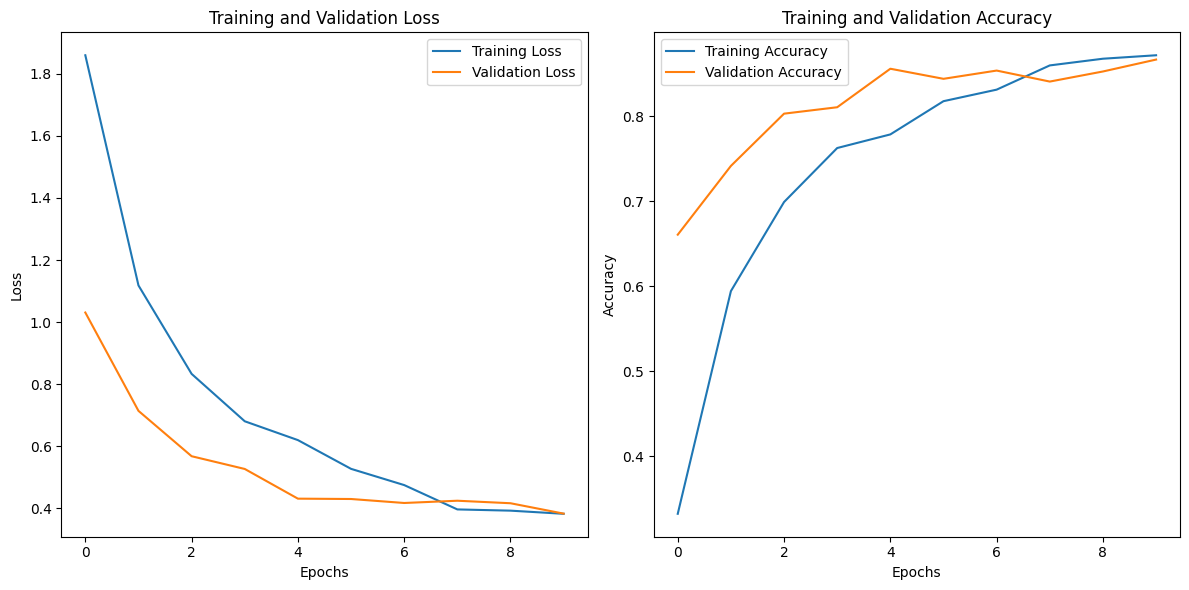

In [ ]:
# Plotting the training and validation loss graph
plt.figure(figsize=(12, 6))

# Plotting loss
plt.subplot(1, 2, 1) #plot on left side
plt.plot(train_model1.history['loss'], label='Training Loss') #label for training loss
plt.plot(train_model1.history['val_loss'], label='Validation Loss') #setting label for validation loss
plt.title('Training and Validation Loss') #setting title
plt.xlabel('Epochs') #setting x label
plt.ylabel('Loss') #setting y label
plt.legend() #plot legend

# Plotting accuracy
plt.subplot(1, 2, 2)#plot on right side
plt.plot(train_model1.history['accuracy'], label='Training Accuracy') #label for training accuracy
plt.plot(train_model1.history['val_accuracy'], label='Validation Accuracy') #setting label for validation accuracy
plt.title('Training and Validation Accuracy') #setting title
plt.xlabel('Epochs') #setting x label
plt.ylabel('Accuracy') #setting y label
plt.legend() #plot legend

# Adjust layout to prevent overlapping
plt.tight_layout()

# Showing the plot
plt.show()

Found 935 images belonging to 9 classes.
30/30 [==============================] - 6s 187ms/step
Classification Report:
                      precision    recall  f1-score   support

      Food Organics       0.93      0.76      0.83        83
              Glass       0.99      0.93      0.96        86
              Metal       0.80      0.94      0.86       161
Miscellaneous Trash       0.86      0.55      0.67        99
              Paper       0.76      0.97      0.85       100
            Plastic       0.85      0.78      0.81       120
         Vegetation       0.81      0.98      0.89        88
            battery       0.96      0.87      0.91        84
            diapers       0.99      0.97      0.98       114

           accuracy                           0.87       935
          macro avg       0.88      0.86      0.86       935
       weighted avg       0.87      0.87      0.86       935

Confusion Matrix:
 [[ 63   0   0   4   1   5  10   0   0]
 [  0  80   4   0   1   0 

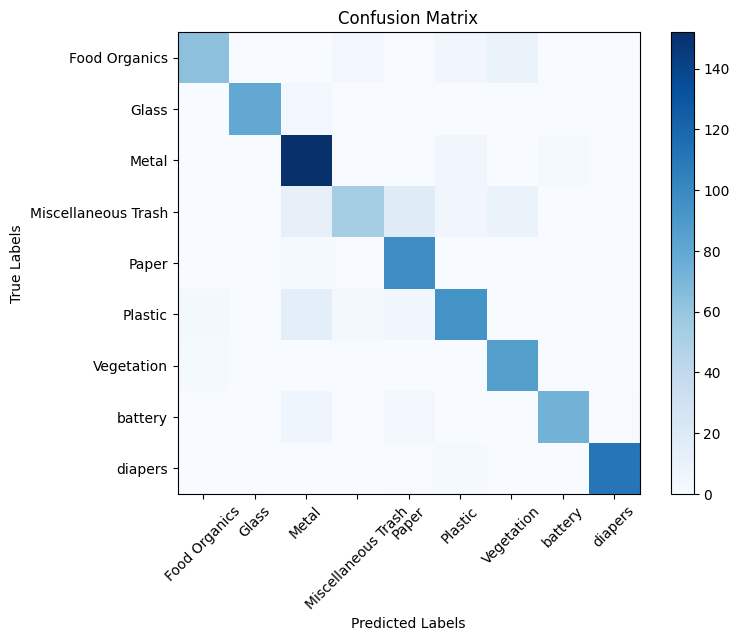

In [ ]:
test_generator = validation_datagen.flow_from_directory( #evaluating model on test_generator data
    os.path.join(dataset_path, 'validation'),
    target_size=(128, 128), #size set to 128x128
    batch_size=32, #32 files processed at one batch
    class_mode='categorical', #for classification tasks
    shuffle=False  # setting the shuffle to False for correct evaluation
)

# Make predictions on the test model
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# converting the predicted probabilites to the class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Generating and print classification report
class_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

# Generating and printing the numerical confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", confusion_mat)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6)) #size of the figure
plt.imshow(confusion_mat, cmap=plt.cm.Blues) #show the confusion matrix
plt.title('Confusion Matrix') #set the title
plt.colorbar() #set the colorbar
plt.xticks(np.arange(len(class_names)), class_names, rotation=45) #set xticks
plt.yticks(np.arange(len(class_names)), class_names) #set yticks 
plt.xlabel('Predicted Labels') #set the x label
plt.ylabel('True Labels') #set the y label
plt.show() #show the graph


In [ ]:
model.save('Data_Science_Final.keras') #saving the model